# Mitigating the noise

<center><img src="../../figures/qibo_mascotte/qibo_mit.png" alt="drawing" width="400"/></center>
<center>Qibo the mangoose mitigating noise [DALL-E].</center>

## Introduction

In lecture 4 we have learnt how to simulate a noisy system using Pauli noise channels.

We typically approach a noisy system in two different ways:

1. **quantum error correction (QEC)**, which involves a series of techniques which aim to detect and remove actively the noise from a bench of qubits of a quantum system. It needs a large number of physical qubits to actually correct and protect the state of a restricted number of them. Thanks to QEC the noise is practically removed (or corrected) from some qubits of a system.
2. **quantum error mitigation (QEM)** consists in a collection of algorithms used to learn a noise map, which is then used to mitigate the noisy results. These methods doesn't correct the noise, but can be seen as post-processing techniques to extract an estimation of the noiseless results on top of the knowledge we have of the system.

In this lecture we are going to focus on a specific QEM technique: the Clifford Data Regression (CDR).

In [1]:
# if you don't have already qibo, qibojit and qiboedu installed in your computer
# uncomment and execute the following lines 

# !pip install qibo
# !pip install qibojit
# !pip install git+https://github.com/qiboteam/qiboedu

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import qibo
from qibo import Circuit, gates, hamiltonians
from qibo.models import error_mitigation
from qibo.noise import PauliError, NoiseModel

In [3]:
qibo.set_backend("numpy")

[Qibo 0.2.15|INFO|2025-01-16 15:56:41]: Using numpy backend on /CPU:0


#### Clifford Data Regression

##### The target circuit 

The idea behind the CDR is very simple and effective: we consider a target circuit $U$, which we aim to execute in order to compute some expectation value 
$$ \langle \mathcal{O} \rangle^U \equiv \langle 0 | U^{\dagger}\, \mathcal{O}\, U | 0 \rangle \\. $$
We are going to inherit the same problem of the lecture 4:

In [4]:
# problem definition
nqubits = 3
nlayers = 3

c = Circuit(nqubits, density_matrix=True)
for l in range(nlayers):
    for q in range(nqubits):
        c.add(gates.RY(q=q, theta=0))
        c.add(gates.RZ(q=q, theta=0))
    for q in range(0, nqubits-1, 1):
        c.add(gates.CNOT(q0=q, q1=q+1))
c.add(gates.M(*range(nqubits)))

# set the angles
nparams = len(c.get_parameters())
angles = np.linspace(0, 2*np.pi, nparams)

# set the angles into the circuit
c.set_parameters(angles)

c.draw()

# observable definition
obs = hamiltonians.Z(nqubits=nqubits)

0: ─RY─RZ─o───RY─RZ─o───RY─RZ─o───M─
1: ─RY─RZ─X─o─RY─RZ─X─o─RY─RZ─X─o─M─
2: ─RY─RZ───X─RY─RZ───X─RY─RZ───X─M─


##### A training set of semi-Clifford circuits
Once the problem is set up, we collect a set of circuits $\{C^i\}$, which have the same dimension of $U$, but they are mostly composed of Clifford gates. The idea is to create a set of circuits whose shape is similar to our target, but they are fastly simulable on a classical computer.

We are going to use the already implemented CDR we have in `qibo`, in which the circuits $C^i$ are generated using the following function

In [5]:
cdr_circuit = error_mitigation.sample_training_circuit_cdr(c)

which changes some of the non-Clifford gates of the circuit with Clifford ones. In this particular case, some of the $RZ$ gates, which are non-Clifford if filled with general angles, are "cliffordized" by replacing the angles with multiples of $\pi/2$. 

In [6]:
print(f"Original circuit:\n")
c.draw()
print("\n")
print(f"Circuit:\n")
cdr_circuit.draw()
print("\n")
print(f"Old angles:\n{angles}\n")
print(f"New angles:\n{cdr_circuit.get_parameters()}\n")

Original circuit:

0: ─RY─RZ─o───RY─RZ─o───RY─RZ─o───M─
1: ─RY─RZ─X─o─RY─RZ─X─o─RY─RZ─X─o─M─
2: ─RY─RZ───X─RY─RZ───X─RY─RZ───X─M─


Circuit:

0: ─RY─RZ─o───RY─RZ─o───RY─RZ─o───M─
1: ─RY─RZ─X─o─RY─RZ─X─o─RY─RZ─X─o─M─
2: ─RY─RZ───X─RY─RZ───X─RY─RZ───X─M─


Old angles:
[0.         0.36959914 0.73919827 1.10879741 1.47839654 1.84799568
 2.21759481 2.58719395 2.95679309 3.32639222 3.69599136 4.06559049
 4.43518963 4.80478876 5.1743879  5.54398704 5.91358617 6.28318531]

New angles:
[(0.0,), (0.0,), (0.7391982714328925,), (1.1087974071493387,), (1.478396542865785,), (1.5707963267948966,), (2.2175948142986774,), (3.141592653589793,), (2.95679308573157,), (3.326392221448016,), (3.6959913571644627,), (4.065590492880909,), (4.435189628597355,), (4.71238898038469,), (5.174387900030248,), (5.543987035746694,), (5.91358617146314,), (6.283185307179586,)]



##### The noise map $\ell$

At this point, we compute both noisy $ \{ \langle \mathcal{O} \rangle^i_{\rm noisy} \}$ and noiseless  $\{\langle \mathcal{O} \rangle^i \}$ expectation values executing the circuits $\{C^i\}$ on a noisy device and on a classical exact simulator.

We then fit the scatterplot $\langle \mathcal{O} \rangle_{\rm noisy}$ vs.  $\langle \mathcal{O} \rangle$ with some map $\ell$.

For doing this, we use the `error_mitigation.CDR` method. 
The method requires a noise model to be defined if we are simulating. In order to reproduce the same noise of lecture 4, we build the following noise model:

In [7]:
noise = NoiseModel()
noise.add(PauliError([("X", 0.007), ("Z", 0.008)]), qubits=0)
noise.add(PauliError([("Y", 0.01), ("Z", 0.005)]), qubits=1)
noise.add(PauliError([("X", 0.008), ("Z", 0.007)]), qubits=2)

Now we are ready to call the mitigation method.

In [8]:
# this will take some time!
mit_exp, noisy_exp, fit_params, training_data = error_mitigation.CDR(
    circuit=c, 
    observable=obs, 
    noise_model=noise,
    nshots=50000,
    n_training_samples=50,
    full_output=True
)

By setting `full_output=True` we are saving many information about the QEM method:
1. the mitigated expectation value;
2. the noisy expectation value;
3. the fitted parameters according to the chosen map form $\ell$;
4. the whole set of $\langle \mathcal{O} \rangle_{\rm noisy}$ and $\langle \mathcal{O} \rangle$ collected using the training circuits $C^i$.

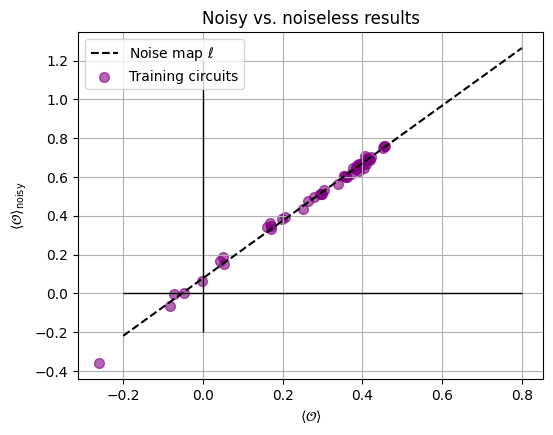

In [9]:
x = np.linspace(-0.2, 0.8, 100)
y = fit_params[0] * x + fit_params[1]

plt.figure(figsize=(6, 6 * 6/8))
plt.title("Noisy vs. noiseless results")
plt.ylabel(r"$\langle \mathcal{O} \rangle_{\rm noisy}$")
plt.xlabel(r"$\langle \mathcal{O} \rangle$")
plt.plot(x, y, color="black", ls="--", label=r"Noise map $\ell$")
plt.scatter(training_data["noisy"], training_data["noise-free"], color="purple", alpha=0.6, s=50, label="Training circuits")
plt.vlines(0, -0.2, 1.2, color="black", ls="-", lw=1)
plt.hlines(0, -0.2, 0.8, color="black", ls="-", lw=1)
plt.grid(True)
plt.legend()
plt.show()

And, thanks to the CDR, we get a cleaner expectation value

In [10]:
print(f"Noisy expectation value: {noisy_exp}")
print(f"Mitigated expectation value: {mit_exp}")
print(f"Noiseless expectation value: {0.602}")

Noisy expectation value: 0.32527999999999996
Mitigated expectation value: 0.561173328355093
Noiseless expectation value: 0.602


Which is closer to the exact one with respect to the noisy result!